In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
%matplotlib inline

symbol = "^GSPC"
start_date = datetime.datetime(2005,1,1)
end_date = datetime.datetime(2005,12,31)
ts = data.DataReader(symbol, "yahoo", start_date, end_date)
ts.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,1213.550049,1217.329956,1211.650024,1211.920044,1211.920044,786900000
2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1202.079956,1510800000
2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1188.050049,1721000000
2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1183.739990,1738900000
2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1187.890015,1569100000


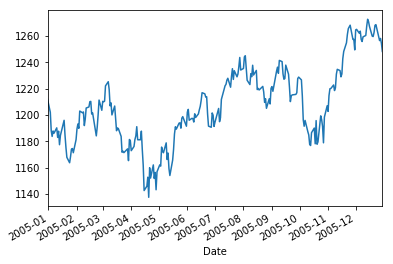

In [2]:
ts['Adj Close'].plot()

In [3]:
def get_direction(price_diff): 
    dt = np.sign(price_diff)
    result = pd.DataFrame({'Direction': dt})
    return result

In [4]:
ts['Pct_Change'] = ts['Close'].pct_change()

In [5]:
a_diff = np.ediff1d(ts[['Close']])
a_diff = np.append(a_diff, [0])
ts['Diff'] = a_diff

In [6]:
ts['Direction'] = get_direction(ts['Diff'])

In [7]:
ts.loc[ts['Direction'] == 0, 'Direction'] = 1

In [8]:
ts.tail()

,Open,High,Low,Close,Adj Close,Volume,Pct_Change,Diff,Direction
Date,,,,,,,,,
2005-12-23,1268.119995,1269.760010,1265.920044,1268.660034,1268.660034,1285810000,0.000426,-12.119995,-1.0
2005-12-27,1268.660034,1271.829956,1256.540039,1256.540039,1256.540039,1540470000,-0.009553,1.630005,1.0
2005-12-28,1256.540039,1261.099976,1256.540039,1258.170044,1258.170044,1422360000,0.001297,-3.750000,-1.0
2005-12-29,1258.170044,1260.609985,1254.180054,1254.420044,1254.420044,1382540000,-0.002981,-6.130005,-1.0
2005-12-30,1254.420044,1254.420044,1246.589966,1248.290039,1248.290039,1443500000,-0.004887,0.000000,1.0


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

n_train = (ts['Close'].count()*0.7).astype(int)

X = ts[['Open', 'High', 'Low', 'Volume']]
y = ts['Close']

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:] 

pipe = Pipeline([("scaler", MinMaxScaler()),("mlp",MLPRegressor(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]))])

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {'mlp__activation':['tanh', 'relu', 'logistic'],
             'mlp__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Beste Genauigkeit nach Kreuzvalidierung: {:.2f}".format(grid.best_score_))
print("Bester Score auf den Testdaten: {:.2f}".format(grid.score(X_test, y_test)))
print("Beste Parameter: {}".format(grid.best_params_))

Beste Genauigkeit nach Kreuzvalidierung: 0.95
Bester Score auf den Testdaten: 0.24
Beste Parameter: {'mlp__activation': 'relu', 'mlp__alpha': 0.1}


In [11]:
def plot_residuen(model):

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='o', label='Trainingsdaten')
    plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen', marker='s', label='Testdaten')
    plt.xlabel('Vorhergesagte Werte')
    plt.ylabel('Residuen')
    plt.hlines(y=0, xmin=1100, xmax=1500, lw=2, color='red')

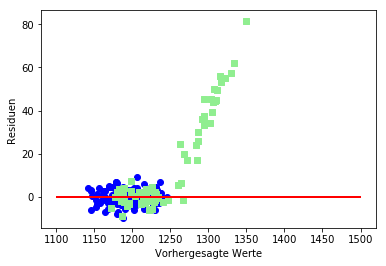

In [12]:
plot_residuen(grid)

In [13]:
y_predict = grid.predict(X)

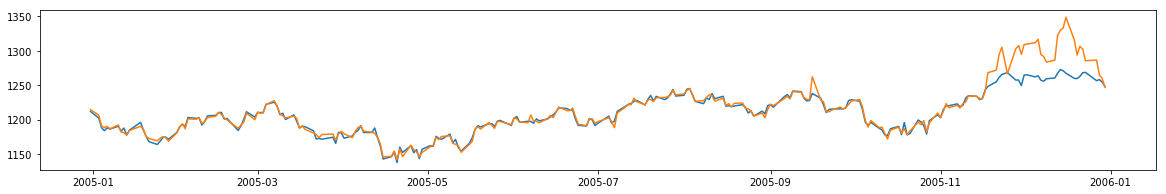

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(ts.index, ts['Close'] , label="close")
plt.plot(ts.index, y_predict , label="close")

In [15]:
def get_bollinger_bands(price_close, window_size, num_of_std):
    rolling_mean = price_close.rolling(window=window_size,min_periods=1).mean()
    rolling_std= price_close.rolling(window=window_size,min_periods=1).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    result = pd.DataFrame({'BB_Mean': rolling_mean, 'BB_Upper': upper_band, 'BB_Lower': lower_band})
    return result

In [16]:
num_of_std = ts['Close'].std()
bollinger_df = get_bollinger_bands(ts['Close'],20,num_of_std)

In [21]:
ts = pd.concat([ts, bollinger_df], axis=1)
ts = ts.dropna()

In [22]:
ts.tail()

,Open,High,Low,Close,Adj Close,Volume,Pct_Change,Diff,Direction,BB_Lower,BB_Mean,BB_Upper,BB_Lower,BB_Mean,BB_Upper
Date,,,,,,,,,,,,,,,
2005-12-23,1268.119995,1269.760010,1265.920044,1268.660034,1268.660034,1285810000,0.000426,-12.119995,-1.0,1092.880778,1262.525494,1432.170211,1092.880778,1262.525494,1432.170211
2005-12-27,1268.660034,1271.829956,1256.540039,1256.540039,1256.540039,1540470000,-0.009553,1.630005,1.0,1091.468595,1262.479498,1433.490402,1091.468595,1262.479498,1433.490402
2005-12-28,1256.540039,1261.099976,1256.540039,1258.170044,1258.170044,1422360000,0.001297,-3.750000,-1.0,1092.371926,1262.514001,1432.656077,1092.371926,1262.514001,1432.656077
2005-12-29,1258.170044,1260.609985,1254.180054,1254.420044,1254.420044,1382540000,-0.002981,-6.130005,-1.0,1107.538381,1262.761005,1417.983628,1107.538381,1262.761005,1417.983628
2005-12-30,1254.420044,1254.420044,1246.589966,1248.290039,1248.290039,1443500000,-0.004887,0.000000,1.0,1080.457657,1261.942004,1443.426351,1080.457657,1261.942004,1443.426351


In [23]:
n_train = (ts['Close'].count()*0.7).astype(int)

X = ts[['Open', 'High', 'Low', 'Volume','BB_Lower','BB_Mean', 'BB_Upper']]
y = ts['Close']

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:] 

pipe = Pipeline([("scaler", MinMaxScaler()),("mlp",MLPRegressor(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]))])

In [24]:
param_grid = {'mlp__activation':['tanh', 'relu', 'logistic'],
             'mlp__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Beste Genauigkeit nach Kreuzvalidierung: {:.2f}".format(grid.best_score_))
print("Bester Score auf den Testdaten: {:.2f}".format(grid.score(X_test, y_test)))
print("Beste Parameter: {}".format(grid.best_params_))

Beste Genauigkeit nach Kreuzvalidierung: 0.95
Bester Score auf den Testdaten: 0.99
Beste Parameter: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001}


In [25]:
y_predict = grid.predict(X)

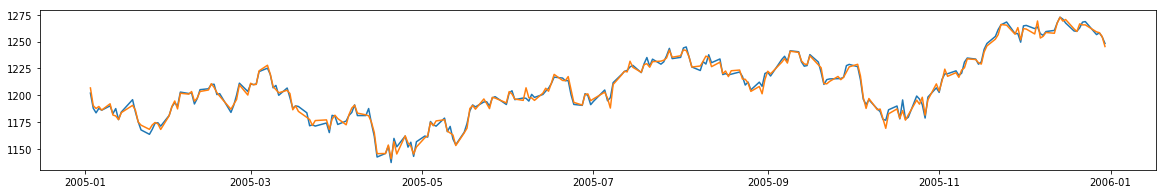

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(ts.index, ts['Close'] , label="close")
plt.plot(ts.index, y_predict , label="close")

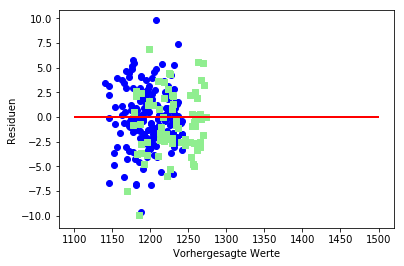

In [27]:
plot_residuen(grid)

In [29]:
ts['SMA14'] = ts['Close'].rolling(window=14,min_periods=1).mean()
ts['SMA30'] = ts['Close'].rolling(window=30,min_periods=1).mean()
ts['EMA14'] = ts['Close'].ewm(span=14,min_periods=1).mean()
ts['EMA30'] = ts['Close'].ewm(span=30,min_periods=1).mean()

In [30]:
ts.tail()

,Open,High,Low,Close,Adj Close,Volume,Pct_Change,Diff,Direction,BB_Lower,BB_Mean,BB_Upper,BB_Lower,BB_Mean,BB_Upper,SMA14,SMA30,EMA14,EMA30
Date,,,,,,,,,,,,,,,,,,,
2005-12-23,1268.119995,1269.760010,1265.920044,1268.660034,1268.660034,1285810000,0.000426,-12.119995,-1.0,1092.880778,1262.525494,1432.170211,1092.880778,1262.525494,1432.170211,1263.875000,1257.340662,1263.286605,1254.227900
2005-12-27,1268.660034,1271.829956,1256.540039,1256.540039,1256.540039,1540470000,-0.009553,1.630005,1.0,1091.468595,1262.479498,1433.490402,1091.468595,1262.479498,1433.490402,1263.363578,1258.067997,1262.387063,1254.377071
2005-12-28,1256.540039,1261.099976,1256.540039,1258.170044,1258.170044,1422360000,0.001297,-3.750000,-1.0,1092.371926,1262.514001,1432.656077,1092.371926,1262.514001,1432.656077,1263.420724,1258.881665,1261.824794,1254.621779
2005-12-29,1258.170044,1260.609985,1254.180054,1254.420044,1254.420044,1382540000,-0.002981,-6.130005,-1.0,1107.538381,1262.761005,1417.983628,1107.538381,1262.761005,1417.983628,1263.319301,1259.728666,1260.837494,1254.608764
2005-12-30,1254.420044,1254.420044,1246.589966,1248.290039,1248.290039,1443500000,-0.004887,0.000000,1.0,1080.457657,1261.942004,1443.426351,1080.457657,1261.942004,1443.426351,1262.527876,1260.298002,1259.164500,1254.201104


In [36]:
n_train = (ts['Close'].count()*0.7).astype(int)

X = ts[['Open', 'High', 'Low', 'Volume','SMA14','SMA30', 'EMA14','EMA30','BB_Lower','BB_Mean', 'BB_Upper']]
y = ts['Close']

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:] 

pipe = Pipeline([("scaler", MinMaxScaler()),("mlp",MLPRegressor(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]))])

In [37]:
param_grid = {'mlp__activation':['tanh', 'relu', 'logistic'],
             'mlp__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Beste Genauigkeit nach Kreuzvalidierung: {:.2f}".format(grid.best_score_))
print("Bester Score auf den Testdaten: {:.2f}".format(grid.score(X_test, y_test)))
print("Beste Parameter: {}".format(grid.best_params_))

Beste Genauigkeit nach Kreuzvalidierung: 0.95
Bester Score auf den Testdaten: 0.99
Beste Parameter: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001}


In [38]:
y_predict = grid.predict(X)

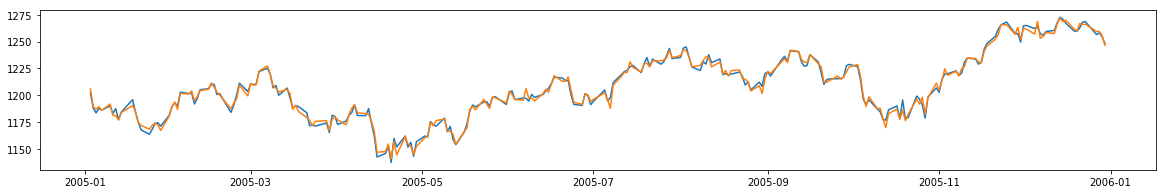

In [39]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(ts.index, ts['Close'] , label="close")
plt.plot(ts.index, y_predict , label="close")

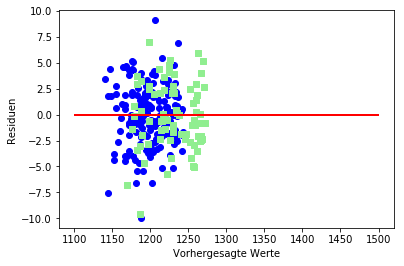

In [40]:
plot_residuen(grid)